# Import data and variables

In [1]:
# import python module

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

from tqdm import tqdm
from scipy.fftpack import fft, ifft, fft2, ifft2, fftfreq, fftshift, ifftshift
from sklearn.metrics import r2_score

In [2]:
# import data file

input_file = '149-1A1.csv'
x_or_y = 'y'                              # data direction for 1D extraction (type 'x' or 'y')
row_no = 250                              # row no. for 1D data extraction

In [3]:
# assign constant

## smoothing Gaussian filter
lambda_s = 1                             # micro-m
freq_s = 1/lambda_s                       # (micro-m)^-1

## cut-off Gaussian filter
lambda_c = 50                            # micro-m
freq_c = 1/lambda_c                       # (micro-m)^-1

## dominant freq
ratio_amp_dom2max_1D = 10                 # %
accept_dom_rSqua_2D = 0.95                   # value from 0 to 1
                                            ## 0 = estimated data 'poorly' fit the reference data
                                            ## 1 = estimated data 'well' fit the reference data

#------------------------------------------------------------------------------------------------------#            
            
## constant for gaussian filter (do not touch)
alfa = 0.4697
beta = 0.2206

In [4]:
# to trim non-related area of data
# ex. processed surface (drill, mill), the interested height is only one part of the measured surface

trim_command = 'n'                        # 'y' if trim, 'n' if not-trim
trim_min = 300                            # mm
trim_max = 1000                           # mm

In [5]:
# to assign length of dominant surface output (.csv)
# cut one corner of the area 

assign_csv_len = 'n'                      # 'y' if assign, 'n' if not-assign
csv_len_1D = 50
csv_len_2D = 50

In [6]:
# assign no. of point for surface reconstruction

data_pnts_recon = 31
elemsize_recon = 30
data_list_recon = np.linspace(0, elemsize_recon, data_pnts_recon)     # numpy.linspace(start, stop, num)
data_len_recon = data_list_recon[-1]
axis_dist_recon = (0, data_len_recon, 0, data_len_recon)

# Data pre-processing

## Data trimming

In [7]:
# import data
df = pd.read_csv(input_file, usecols=['# X','Y','Z'], skiprows=6)
df = df.rename(index=str, columns={"# X": "X"})

df.head()

X    Y        Z
0  0.0000  0.0 -16.4885
1  1.5625  0.0 -17.6490
2  3.1250  0.0 -16.3623
3  4.6875  0.0 -16.0251
4  6.2500  0.0 -14.9010

In [8]:
# trim input data to be square

x_list = sorted(list(set(df['X'])))
y_list = sorted(list(set(df['Y'])))

x_pnts = len(x_list)
y_pnts = len(y_list)
data_pnts = min(x_pnts, y_pnts)


# no of data point after cut = even

if data_pnts % 2 != 0:
    data_pnts = data_pnts - 1
    
data_list = x_list[0:data_pnts]
data_len = data_list[-1]
    
    
print(x_pnts)
print(y_pnts)
print(data_pnts)

2197
2202
2196


In [9]:
# pivot table

df_raw = df.pivot_table(values='Z', index='Y', columns='X', aggfunc='first')
df_raw = df_raw.iloc[0:data_pnts, 0:data_pnts]

df_raw.iloc[0:5,0:5]

X        0.0000   1.5625   3.1250   4.6875   6.2500
Y                                                  
0.0000 -16.4885 -17.6490 -16.3623 -16.0251 -14.9010
1.5625 -16.5843 -16.5800 -17.1470 -17.0203 -15.8938
3.1250 -17.4205 -17.2044 -16.4720 -15.4936 -14.8407
4.6875 -16.6574 -17.0140 -16.1469 -13.7319 -13.9038
6.2500 -16.8450 -16.3267 -16.3333 -13.8033 -13.5738

In [10]:
# find index of trim_min, trim_max

if trim_command == 'y':

    trim_min_loc = 0
    trim_max_loc = 0

    for i in range(len(data_list)):
        if data_list[i] > trim_min:
            trim_min_loc = i
            break

    for i in range(len(data_list)):
        if data_list[len(data_list)-1-i] < trim_max:
            trim_max_loc = len(data_list)-1-i
            break
    
    if (trim_max_loc - trim_min_loc) % 2 != 0:               # no of data point after cut = even
        trim_min_loc = trim_min_loc + 1

In [11]:
# pivot table

if trim_command == 'y':
    df_2D = df.pivot_table(values='Z', index='Y', columns='X', aggfunc='first')
    df_2D = df_2D.iloc[trim_min_loc:trim_max_loc, trim_min_loc:trim_max_loc]

    df_2D.iloc[0:5,0:5]

In [12]:
# plot trimmed surface

if trim_command == 'y':

    # set axis
    axis_dist_raw = (0, data_len, 0, data_len)                                          
    axis_dist_2D = (data_list[trim_min_loc], data_list[trim_max_loc], data_list[trim_min_loc], data_list[trim_max_loc])                                         
    v_min_raw = np.amin(df_raw.values)
    v_max_raw = np.amax(df_raw.values)


    plot_size = (8, 4)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
    f.suptitle("Trimmed surface", fontsize=16)

    ax1.imshow(df_raw, extent=axis_dist_raw, vmin=v_min_raw, vmax=v_max_raw)
    ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax1.title.set_text('Raw surface')
    ax1.grid(False)

    ax2.imshow(df_2D, extent=axis_dist_2D, vmin=v_min_raw, vmax=v_max_raw) 
    ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax2.title.set_text('Trimmed surface')
    ax2.grid(False)

    plt.tight_layout()
    f.subplots_adjust(top=0.88)

In [13]:
# assign spatial axis

if trim_command == 'y':
    
    data_list = x_list[0:trim_max_loc-trim_min_loc]
    data_len = data_list[-1]
    data_pnts = len(data_list)

    print(trim_min_loc)
    print(trim_max_loc)
    print(data_pnts)

In [14]:
if trim_command == 'n':
    df_2D = df_raw.copy()

## Axis assigns

In [15]:
# show spatial axis

print(data_list[0:5], "...", data_list[-5:])
print(data_len)
print(data_pnts)

[0.0, 1.5625, 3.125, 4.6875, 6.25] ... [3423.44, 3425.0, 3426.56, 3428.12, 3429.69]
3429.69
2196


In [16]:
# sampling info

samp_space = data_list[1] - data_list[0]             # micro-m
samp_rate = 1/samp_space                             # (micro-m)^(-1)

print(samp_space)
print(samp_rate)

1.5625
0.64


In [17]:
# assign freq axis

freq_full = fftfreq(data_pnts, samp_space)
freq_full_shift = fftshift(freq_full)
freq_half = freq_full_shift[freq_full_shift >= 0]

print(freq_full[0:5], "...", freq_full[-5:])
print(freq_full_shift[0:5], "...", freq_full_shift[-5:])
print(freq_half[0:5], "...", freq_half[-5:])

[0.         0.00029144 0.00058288 0.00087432 0.00116576] ... [-0.00145719 -0.00116576 -0.00087432 -0.00058288 -0.00029144]
[-0.32       -0.31970856 -0.31941712 -0.31912568 -0.31883424] ... [0.31854281 0.31883424 0.31912568 0.31941712 0.31970856]
[0.         0.00029144 0.00058288 0.00087432 0.00116576] ... [0.31854281 0.31883424 0.31912568 0.31941712 0.31970856]


## Extract row of data (1D)

In [18]:
# check selection in x or y direction
# extract out row of data

if x_or_y == 'x':
    z_data = df_2D.iloc[:, row_no].values
        
if x_or_y == 'y':
    z_data = df_2D.iloc[row_no, :].values

# Gaussian filter

## 1D-Gaussian

In [19]:
# create gaussian 1D

df_gauss_1D = pd.DataFrame(data = freq_full_shift, columns = ['freq']) 
df_gauss_1D['f_to_fc'] = df_gauss_1D['freq'] / freq_c
df_gauss_1D['low_gauss'] = np.exp(-np.pi * (alfa * df_gauss_1D['f_to_fc'])**2)
df_gauss_1D['high_gauss'] = 1 - df_gauss_1D['low_gauss']

df_gauss_1D.head()

freq    f_to_fc     low_gauss  high_gauss
0 -0.320000 -16.000000  8.758648e-78         1.0
1 -0.319709 -15.985428  1.209854e-77         1.0
2 -0.319417 -15.970856  1.670710e-77         1.0
3 -0.319126 -15.956284  2.306436e-77         1.0
4 -0.318834 -15.941712  3.183126e-77         1.0

In [20]:
low_gauss_1D = df_gauss_1D['low_gauss'].values
high_gauss_1D = df_gauss_1D['high_gauss'].values

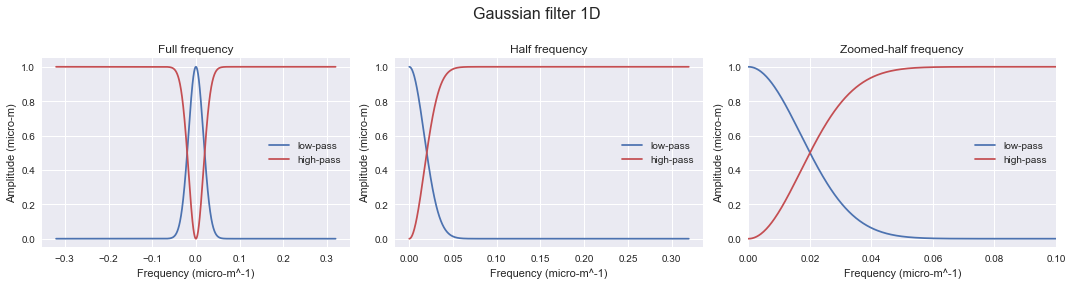

In [21]:
plot_size = (15, 4)
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Gaussian filter 1D", fontsize=16)

ax1.plot(freq_full_shift, low_gauss_1D, 'b')
ax1.plot(freq_full_shift, high_gauss_1D, 'r')
ax1.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax1.title.set_text('Full frequency')
ax1.legend(('low-pass','high-pass'), loc='center right')

ax2.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
ax2.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
ax2.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax2.title.set_text('Half frequency')
ax2.legend(('low-pass','high-pass'), loc='center right')

ax3.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
ax3.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
ax3.set_xlim(0, freq_c*5)
ax3.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax3.title.set_text('Zoomed-half frequency')
ax3.legend(('low-pass','high-pass'), loc='center right')

plt.tight_layout()
f.subplots_adjust(top=0.8)

## 1D-Gaussian smoothing filter

In [22]:
# create gaussian smoothing filter 1D

df_gauss_1D['f_to_fs'] = df_gauss_1D['freq'] / freq_s
df_gauss_1D['smooth_gauss'] = np.exp(-np.pi * (alfa * df_gauss_1D['f_to_fs'])**2)

df_gauss_1D.head()

freq    f_to_fc     low_gauss  high_gauss   f_to_fs  smooth_gauss
0 -0.320000 -16.000000  8.758648e-78         1.0 -0.320000      0.931487
1 -0.319709 -15.985428  1.209854e-77         1.0 -0.319709      0.931608
2 -0.319417 -15.970856  1.670710e-77         1.0 -0.319417      0.931728
3 -0.319126 -15.956284  2.306436e-77         1.0 -0.319126      0.931848
4 -0.318834 -15.941712  3.183126e-77         1.0 -0.318834      0.931968

In [23]:
smooth_gauss_1D = df_gauss_1D['smooth_gauss'].values

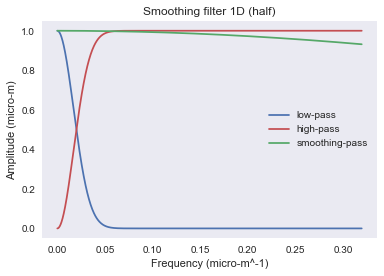

In [24]:
plt.title('Smoothing filter 1D (half)')

plt.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
plt.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
plt.plot(freq_half, smooth_gauss_1D[data_pnts//2:], 'g')

plt.ylabel('Amplitude (micro-m)')
plt.xlabel('Frequency (micro-m^-1)')
plt.legend(('low-pass','high-pass','smoothing-pass'), loc='center right')

plt.grid()
plt.show()

## 2D-Gaussian

In [25]:
# prepare fx/fc and fy/fc to put in equation

df_fx = pd.DataFrame(np.zeros((data_pnts, data_pnts)))

for i in range(data_pnts):
    df_fx.iloc[i,:] = freq_full_shift                             # row by rows
    

df_fy = pd.DataFrame(np.zeros((data_pnts, data_pnts)))

for i in range(data_pnts):
    df_fy.iloc[:,i] = freq_full_shift                             # column by columns


df_fx2fc = df_fx.copy() / freq_c
df_fy2fc = df_fy.copy() / freq_c

In [26]:
# input fx/fc and fy/fc to compute Gaussian

df_low_gauss = np.exp(-np.pi * beta * (df_fx2fc.pow(2) + df_fy2fc.pow(2)))
df_high_gauss = 1 - df_low_gauss

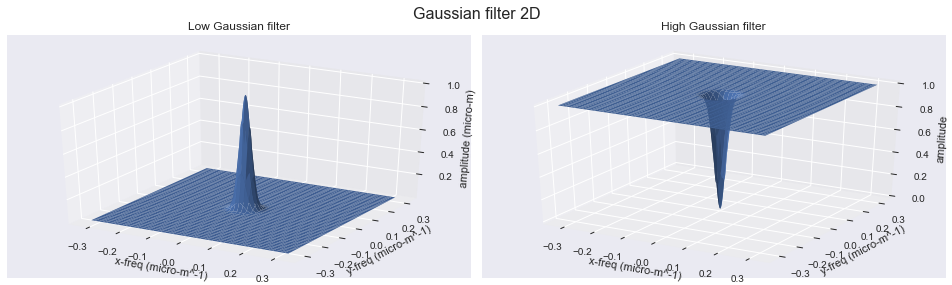

In [27]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Gaussian filter 2D', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = df_low_gauss

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Low Gaussian filter')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = df_high_gauss

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude')
ax.title.set_text('High Gaussian filter')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## 2D-Gaussian smoothing filter

In [28]:
# prepare fx/fc and fy/fc to put in equation

df_fx2fs = df_fx.copy() / freq_s
df_fy2fs = df_fy.copy() / freq_s

In [29]:
# input fx/fc and fy/fc to compute Gaussian

df_smooth_gauss = np.exp(-np.pi * beta * (df_fx2fs.pow(2) + df_fy2fs.pow(2)))

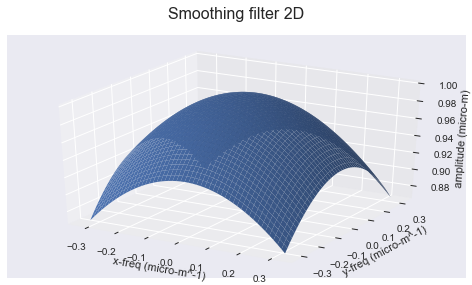

In [30]:
fig = plt.figure(figsize=plt.figaspect(0.6))
fig.suptitle('Smoothing filter 2D', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = df_smooth_gauss

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

# Surface transformation

## 1D-data

### Fourier transform

In [31]:
z_fou_1D = fft(z_data) 
z_inv_1D = ifft(z_fou_1D)

In [32]:
# shift freq domain to multiply with Gaussian

z_fou_1D_shift = fftshift(z_fou_1D)


# amplitude of z-fourier

z_fou_1D_full = 1/data_pnts * abs(z_fou_1D_shift)
z_fou_1D_half = 2/data_pnts * abs(z_fou_1D[0:data_pnts//2])    # fourier amplitude correction
                                                               # [0:data_pnts//2] : to cut only positive half of freq
                                                               # abs() : to get magnitude
                                                               # /data_pnts : to normalized operation of FFT summation
                                                               # *2 : to supplement value of f negative to f positive

In [33]:
# set limit for graph plot (1D)

plt_dist_xlim_1D = data_len
plt_dist_zlim_1D = max(np.amax(z_data), abs(np.amin(z_data))) * 1.3
plt_freq_xlim_1D = samp_rate
plt_freq_zlim_1D = np.amax(z_fou_1D_half) * 1.3

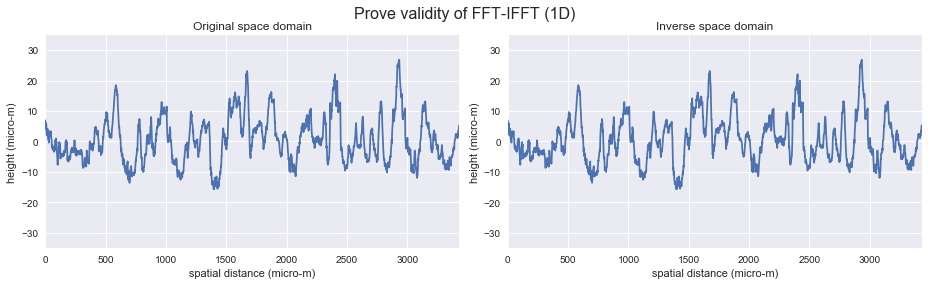

In [34]:
# prove validity of Fourier transform after cut outlier

plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Prove validity of FFT-IFFT (1D)", fontsize=16)

ax1.plot(data_list, z_data)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Original space domain')

ax2.plot(data_list, z_inv_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Inverse space domain')

plt.tight_layout()
f.subplots_adjust(top=0.88)

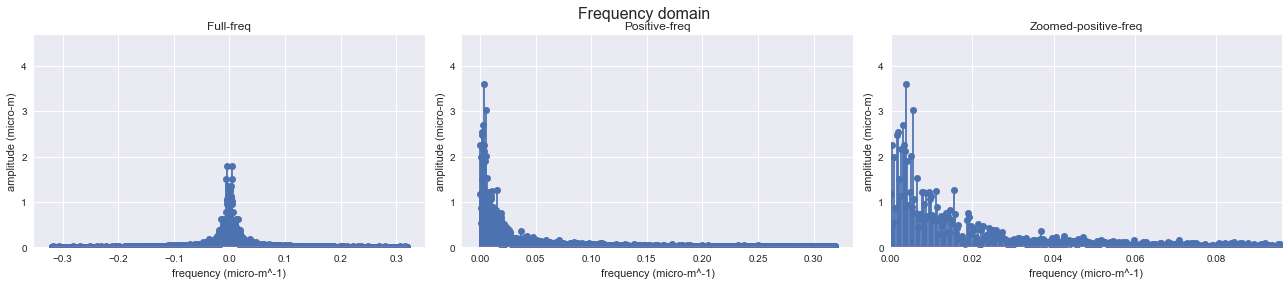

In [35]:
# plot freq domain

plot_size = (18, 4)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Frequency domain", fontsize=16)

ax1.stem(freq_full_shift, z_fou_1D_full)
ax1.set_ylim(0, plt_freq_zlim_1D)
ax1.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax1.title.set_text('Full-freq')

ax2.stem(freq_half, z_fou_1D_half)
ax2.set_ylim(0, plt_freq_zlim_1D)
ax2.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax2.title.set_text('Positive-freq')

ax3.stem(freq_half, z_fou_1D_half)
ax3.set_xlim(0, plt_freq_xlim_1D * 0.15)
ax3.set_ylim(0, plt_freq_zlim_1D)
ax3.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax3.title.set_text('Zoomed-positive-freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [36]:
# compare result

rSq_fft_1D = r2_score(z_data, z_inv_1D.real)

print('Prove validity of Fourier transform 1D')
print('R-square: ', rSq_fft_1D)

Prove validity of Fourier transform 1D
R-square:  1.0


### Smoothing filter

In [37]:
# assign dataframe for operation

df_conv_1D = pd.DataFrame(data=freq_full_shift, columns=['freq'])
df_conv_1D['z_fou'] = z_fou_1D_shift
df_conv_1D['low_gauss'] = low_gauss_1D
df_conv_1D['high_gauss'] = high_gauss_1D
df_conv_1D['smooth_gauss'] = smooth_gauss_1D

In [38]:
df_conv_1D['smooth_conv'] = df_conv_1D['z_fou'] * df_conv_1D['smooth_gauss']

df_conv_1D.head()

freq                                      z_fou     low_gauss  \
0 -0.320000                   (-14.992228857699956+0j)  8.758648e-78   
1 -0.319709    (5.865513320665286-20.018162095630032j)  1.209854e-77   
2 -0.319417       (8.4806528200005+9.514975173655815j)  1.670710e-77   
3 -0.319126  (-26.305675147113107+10.138613020652826j)  2.306436e-77   
4 -0.318834      (15.91801028315291+8.90163044577065j)  3.183126e-77   

   high_gauss  smooth_gauss                               smooth_conv  
0         1.0      0.931487                  (-13.965071962035836+0j)  
1         1.0      0.931608    (5.464357672918578-18.64907496835705j)  
2         1.0      0.931728    (7.901661935914559+8.865369063751361j)  
3         1.0      0.931848  (-24.512896369328118+9.447648422407353j)  
4         1.0      0.931968    (14.83508101844145+8.296037413607953j)

In [39]:
# shift freq domain back for IFFT operation

z_fou_1D_ishift = ifftshift(df_conv_1D['z_fou'].values)
z_fou_smooth_1D_ishift = ifftshift(df_conv_1D['smooth_conv'].values)

In [40]:
# correct freq amplitude for graph plot

z_fou_smooth_1D_full = 1/data_pnts * abs(z_fou_smooth_1D_ishift)
z_fou_smooth_1D_half = 2/data_pnts * abs(z_fou_smooth_1D_ishift[0:data_pnts//2])

In [41]:
# inverse Fourier transform

z_inv_1D = ifft(z_fou_1D_ishift)
z_inv_smooth_1D = ifft(z_fou_smooth_1D_ishift)

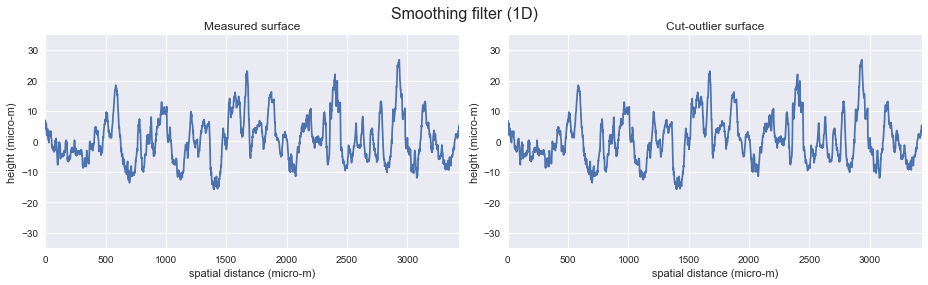

In [42]:
plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Smoothing filter (1D)", fontsize=16)

ax1.plot(data_list, z_data)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Measured surface')

ax2.plot(data_list, z_inv_smooth_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Cut-outlier surface')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [43]:
# compare result

rSq_ori_corr_1D = r2_score(z_data, z_inv_smooth_1D.real)

print('Original to cut-outlier surface')
print('R-square: ', rSq_ori_corr_1D)

Original to cut-outlier surface
R-square:  0.9999962472100812


### Waviness-Roughness filter

In [44]:
# convolution by mulplication in freq domain

df_conv_1D['low_conv'] = df_conv_1D['smooth_conv'] * df_conv_1D['low_gauss']
df_conv_1D['high_conv'] = df_conv_1D['smooth_conv'] * df_conv_1D['high_gauss']

df_conv_1D.head()

freq                                      z_fou     low_gauss  \
0 -0.320000                   (-14.992228857699956+0j)  8.758648e-78   
1 -0.319709    (5.865513320665286-20.018162095630032j)  1.209854e-77   
2 -0.319417       (8.4806528200005+9.514975173655815j)  1.670710e-77   
3 -0.319126  (-26.305675147113107+10.138613020652826j)  2.306436e-77   
4 -0.318834      (15.91801028315291+8.90163044577065j)  3.183126e-77   

   high_gauss  smooth_gauss                               smooth_conv  \
0         1.0      0.931487                  (-13.965071962035836+0j)   
1         1.0      0.931608    (5.464357672918578-18.64907496835705j)   
2         1.0      0.931728    (7.901661935914559+8.865369063751361j)   
3         1.0      0.931848  (-24.512896369328118+9.447648422407353j)   
4         1.0      0.931968    (14.83508101844145+8.296037413607953j)   

                                           low_conv  \
0                      (-1.2231514659960868e-76+0j)   
1   (6.611075612318302e-77-2.2562660077437814e-76j)   
2  (1.3201386974864977e-76+1.4811462276515654e-76j)   
3  (-5.653742504392042e-76+2.1790395817587724e-76j)   
4   (4.722193345233439e-76+2.6407333143410648e-76j)   

                                  high_conv  
0                  (-13.965071962035836+0j)  
1    (5.464357672918578-18.64907496835705j)  
2    (7.901661935914559+8.865369063751361j)  
3  (-24.512896369328118+9.447648422407353j)  
4    (14.83508101844145+8.296037413607953j)

In [45]:
# shift freq domain back for IFFT operation

z_fou_low_1D_ishift = ifftshift(df_conv_1D['low_conv'].values)
z_fou_high_1D_ishift = ifftshift(df_conv_1D['high_conv'].values)

In [46]:
# correct freq amplitude for graph plot

z_fou_low_1D_full = 1/data_pnts * abs(z_fou_low_1D_ishift)
z_fou_low_1D_half = 2/data_pnts * abs(z_fou_low_1D_ishift[0:data_pnts//2])

z_fou_high_1D_full = 1/data_pnts * abs(z_fou_high_1D_ishift)
z_fou_high_1D_half = 2/data_pnts * abs(z_fou_high_1D_ishift[0:data_pnts//2])

In [47]:
# inverse Fourier transform

z_inv_low_1D = ifft(z_fou_low_1D_ishift)
z_inv_high_1D = ifft(z_fou_high_1D_ishift)

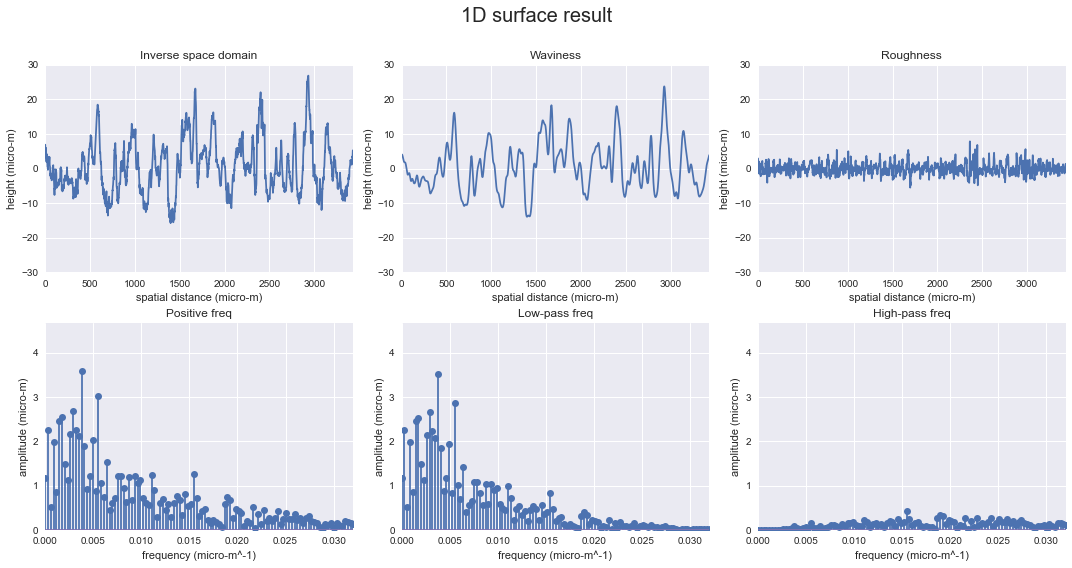

In [48]:
plot_size = (15, 8)
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=plot_size)
f.suptitle("1D surface result", fontsize=20)

ax1.plot(data_list, z_inv_smooth_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-30, 30)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Inverse space domain')

ax2.plot(data_list, z_inv_low_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-30, 30)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Waviness')

ax3.plot(data_list, z_inv_high_1D.real)
ax3.set_xlim(0, plt_dist_xlim_1D)
ax3.set_ylim(-30, 30)
ax3.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax3.title.set_text('Roughness')

ax4.stem(freq_half, z_fou_smooth_1D_half)
ax4.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax4.set_ylim(0, plt_freq_zlim_1D)
ax4.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax4.title.set_text('Positive freq')

ax5.stem(freq_half, z_fou_low_1D_half)
ax5.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax5.set_ylim(0, plt_freq_zlim_1D)
ax5.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax5.title.set_text('Low-pass freq')

ax6.stem(freq_half, z_fou_high_1D_half)
ax6.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax6.set_ylim(0, plt_freq_zlim_1D)
ax6.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax6.title.set_text('High-pass freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

## 2D-data

### Fourier transform

In [49]:
z_fou_2D = fft2(df_2D)
z_inv_2D = ifft2(z_fou_2D)

In [50]:
# shift freq domain to plot graph

z_fou_2D_shift = fftshift(z_fou_2D)

In [51]:
# set limit for graph plot (2D)

axis_dist = (0, data_len, 0, data_len) 
axis_freq = (0, samp_rate, 0, samp_rate)         
v_min_dist = np.amin(z_inv_2D.real)
v_max_dist = np.amax(z_inv_2D.real)
v_min_fAmp = np.amin(np.log10(1/data_pnts**2 * abs(z_fou_2D_shift)))
v_max_fAmp = np.amax(np.log10(1/data_pnts**2 * abs(z_fou_2D_shift)))
v_min_fPhs = np.amin(np.angle(z_fou_2D_shift))
v_max_fPhs = np.amax(np.angle(z_fou_2D_shift))

plt_dist_xlim_2D = data_len
plt_dist_zlim_2D = max(np.amax(df_2D.values), abs(np.amin(df_2D.values))) * 1.3
plt_freq_xlim_2D = samp_rate
plt_freq_zlim_2D = np.amax(z_fou_2D)/data_pnts**2 * 1.3

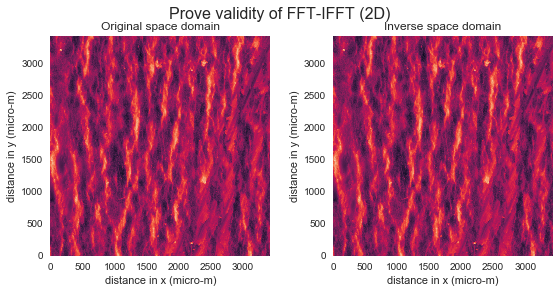

In [52]:
# prove validity of Fourier transform after cut outlier

plot_size = (8, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Prove validity of FFT-IFFT (2D)", fontsize=16)

ax1.imshow(df_2D, extent=axis_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Original space domain')
ax1.grid(False)

ax2.imshow(z_inv_2D.real, extent=axis_dist) 
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Inverse space domain')
ax2.grid(False)

plt.tight_layout()
f.subplots_adjust(top=0.88)

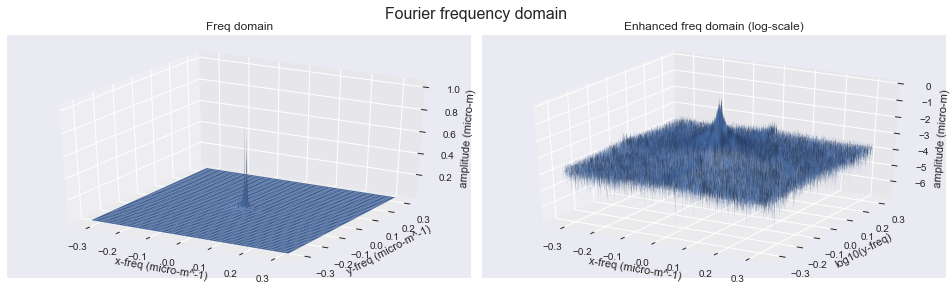

In [53]:
# plot freq domain
# enhance freq domain by log-scale to show difference of freq hight


fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Fourier frequency domain', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_2D_shift)

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq domain')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = np.log10(1/data_pnts**2 * abs(z_fou_2D_shift))                   # log10 to enhance value difference

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='log10(y-freq)', zlabel='amplitude (micro-m)')
ax.title.set_text('Enhanced freq domain (log-scale)')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [54]:
# compare result

rSq_fft_2D = r2_score(df_2D, z_inv_2D.real)

print('Prove validity of Fourier transform 2D')
print('R-square: ', rSq_fft_2D)

Prove validity of Fourier transform 2D
R-square:  1.0


### Smoothing filter

In [55]:
# smoothing convolution

z_fou_smooth_2D = np.multiply(z_fou_2D_shift, df_smooth_gauss)

In [56]:
# shift freq domain back for IFFT operation

z_fou_2D_ishift = ifftshift(z_fou_2D_shift)
z_fou_smooth_2D_ishift = ifftshift(z_fou_smooth_2D)

In [57]:
# inverse Fourier transform

z_inv_2D = ifft2(z_fou_2D_ishift)
z_inv_smooth_2D = ifft2(z_fou_smooth_2D_ishift)

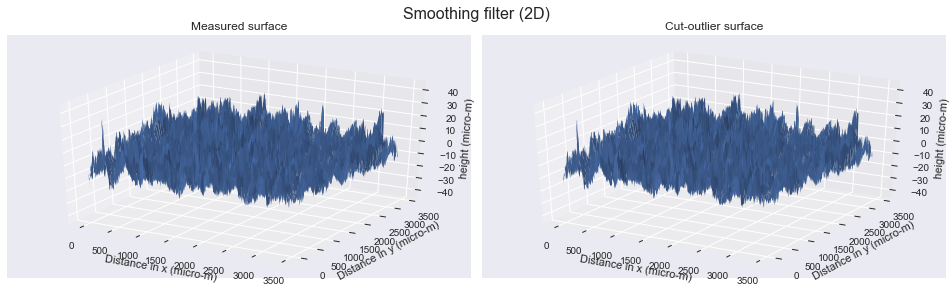

In [58]:
fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Smoothing filter (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Measured surface')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Cut-outlier surface')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [59]:
# compare result

rSq_ori_corr_2D = r2_score(df_2D, z_inv_smooth_2D.real)

print('Original to cut-outlier surface')
print('R-square: ', rSq_ori_corr_2D)

Original to cut-outlier surface
R-square:  0.9999869029323353


### Waviness-Roughness filter

In [60]:
# convolution by element-wise mulplication in freq domain

## low-pass convolution
z_fou_low_2D = np.multiply(z_fou_smooth_2D, df_low_gauss)


## high-pass convolution
z_fou_high_2D = np.multiply(z_fou_smooth_2D, df_high_gauss)

In [61]:
# shift freq domain back for IFFT operation

z_fou_low_2D_ishift = ifftshift(z_fou_low_2D)
z_fou_high_2D_ishift = ifftshift(z_fou_high_2D)

In [62]:
# inverse Fourier transform

z_inv_low_2D = ifft2(z_fou_low_2D_ishift)
z_inv_high_2D = ifft2(z_fou_high_2D_ishift)

D:\Program\Python\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


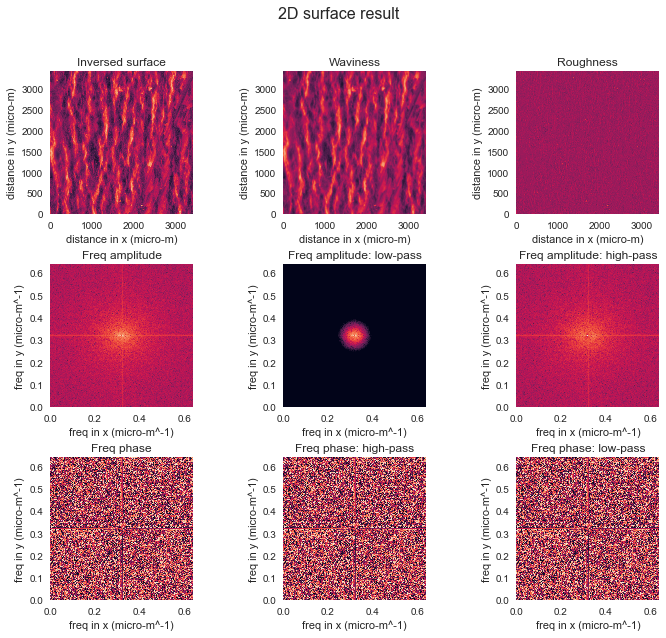

In [63]:
# image plot

plot_size = (10, 9)
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=plot_size)
f.suptitle("2D surface result", fontsize=16)

ax1.imshow(z_inv_smooth_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Inversed surface')
ax1.grid(False)

ax2.imshow(z_inv_low_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Waviness')
ax2.grid(False)

ax3.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax3.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax3.title.set_text('Roughness')
ax3.grid(False)

ax4.imshow(np.log10(1/data_pnts**2 * abs(z_fou_smooth_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)    # log10 to enhance the result
ax4.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax4.title.set_text('Freq amplitude')
ax4.grid(False)

ax5.imshow(np.log10(1/data_pnts**2 * abs(z_fou_low_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)      # log10 to enhance the result
ax5.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax5.title.set_text('Freq amplitude: low-pass')
ax5.grid(False)

ax6.imshow(np.log10(1/data_pnts**2 * abs(z_fou_high_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)      # log10 to enhance the result
ax6.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax6.title.set_text('Freq amplitude: high-pass')
ax6.grid(False)

ax7.imshow(np.angle(z_fou_smooth_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
ax7.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax7.title.set_text('Freq phase')
ax7.grid(False)

ax8.imshow(np.angle(z_fou_low_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
ax8.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax8.title.set_text('Freq phase: high-pass')
ax8.grid(False)

ax9.imshow(np.angle(z_fou_high_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
ax9.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax9.title.set_text('Freq phase: low-pass')
ax9.grid(False)

plt.tight_layout()
f.subplots_adjust(top=0.88)

D:\Program\Python\lib\site-packages\matplotlib\transforms.py:963: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


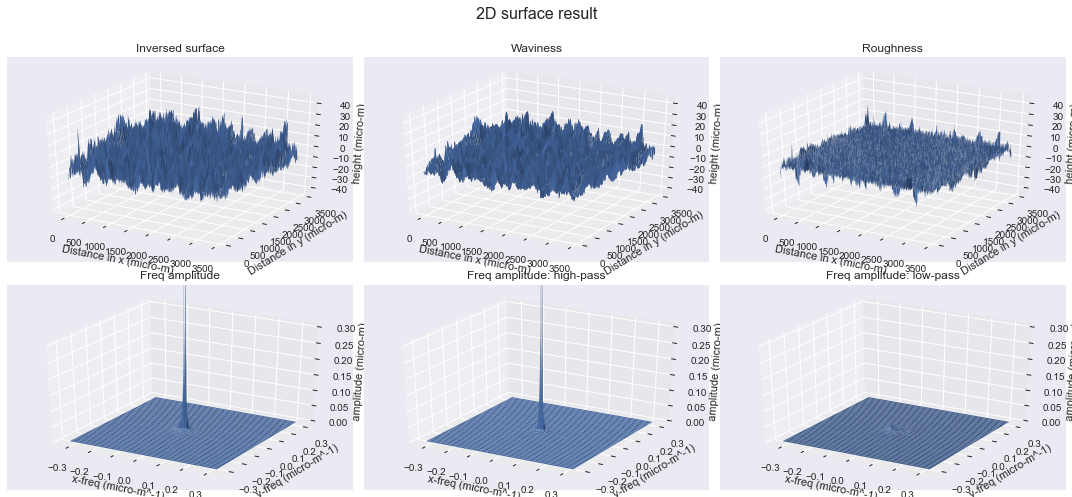

In [64]:
# surface plot

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plot_size = (15, 7)
fig = plt.figure(figsize=plot_size)                                     # set up figure size
fig.suptitle('2D surface result', fontsize=16)


# First subplot
ax = fig.add_subplot(2, 3, 1, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Inversed surface')


# Second subplot
ax = fig.add_subplot(2, 3, 2, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_low_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Waviness')


# third subplot
ax = fig.add_subplot(2, 3, 3, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness')


# fourth subplot
ax = fig.add_subplot(2, 3, 4, projection='3d')          

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_smooth_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq amplitude')


# fifth subplot
ax = fig.add_subplot(2, 3, 5, projection='3d')            

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_low_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq amplitude: high-pass')


# sixth subplot
ax = fig.add_subplot(2, 3, 6, projection='3d')            

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_high_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq amplitude: low-pass')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## 1D and 2D surface comparison

In [65]:
# extract row of 2D surface transformation to compare with 1D surface transformation

if x_or_y == 'x': 
    z_inv_select = z_inv_smooth_2D[:, row_no]
    z_inv_select_low = z_inv_low_2D[:, row_no]
    z_inv_select_high = z_inv_high_2D[:, row_no]
        
if x_or_y == 'y':
    z_inv_select = z_inv_smooth_2D[row_no, :]
    z_inv_select_low = z_inv_low_2D[row_no, :]
    z_inv_select_high = z_inv_high_2D[row_no, :]

D:\Program\Python\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


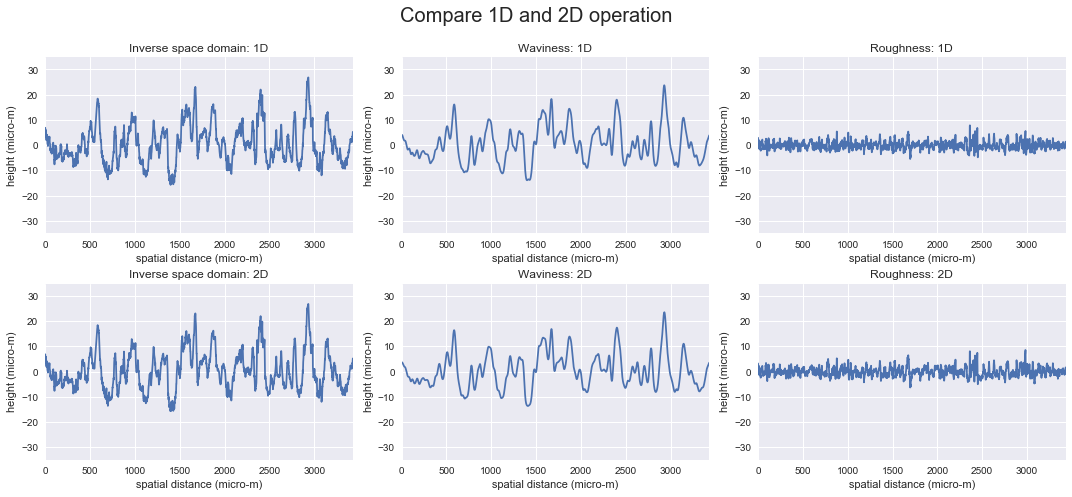

In [66]:
# plot compare 1D and 2D result in 1D-display

plot_size = (15, 7)
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=plot_size)
f.suptitle("Compare 1D and 2D operation", fontsize=20)

ax1.plot(data_list, z_inv_smooth_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Inverse space domain: 1D')

ax2.plot(data_list, z_inv_low_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Waviness: 1D')

ax3.plot(data_list, z_inv_high_1D.real)
ax3.set_xlim(0, plt_dist_xlim_1D)
ax3.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax3.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax3.title.set_text('Roughness: 1D')

ax4.plot(data_list, z_inv_select)
ax4.set_xlim(0, plt_dist_xlim_1D)
ax4.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax4.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax4.title.set_text('Inverse space domain: 2D')

ax5.plot(data_list, z_inv_select_low)
ax5.set_xlim(0, plt_dist_xlim_1D)
ax5.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax5.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax5.title.set_text('Waviness: 2D')

ax6.plot(data_list, z_inv_select_high)
ax6.set_xlim(0, plt_dist_xlim_1D)
ax6.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax6.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax6.title.set_text('Roughness: 2D')


plt.tight_layout()
f.subplots_adjust(top=0.88)

In [67]:
# compare result

rSq_inv_1D2D = r2_score(z_inv_select, z_inv_smooth_1D.real)
rSq_wav_1D2D = r2_score(z_inv_select_low, z_inv_low_1D.real)
rSq_rou_1D2D = r2_score(z_inv_select_high,z_inv_high_1D.real)

print('Inverse space domain - 1D to 2D')
print('R-square: ', rSq_inv_1D2D)
print('\nWaviness - 1D to 2D')
print('R-square: ', rSq_wav_1D2D)
print('\nRoughness - 1D to 2D')
print('R-square: ', rSq_rou_1D2D)

D:\Program\Python\lib\site-packages\numpy\core\_methods.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims)


Inverse space domain - 1D to 2D
R-square:  0.9999966046358405

Waviness - 1D to 2D
R-square:  0.992312967959509

Roughness - 1D to 2D
R-square:  0.8905303156062218


# Dominant frequency

## 1D dominant freq

In [68]:
# automatically assign cut-off amplitude by ratio to max value of freq

freq_dom_amp_c_1D = ratio_amp_dom2max_1D * z_fou_high_1D_half.max() / 100    # value as shown in graph (half-range)
freq_dom_amp_c_1D_full = freq_dom_amp_c_1D/2                                 # value for extraction operation (full-range)

print(freq_dom_amp_c_1D)
print(freq_dom_amp_c_1D_full)

0.04267454974494623
0.021337274872473114


In [69]:
# create dataframe for operation

df_freq_dom_1D = pd.DataFrame(data=freq_full, columns=['freq'])
df_freq_dom_1D['high_conv'] = z_fou_high_1D_ishift
df_freq_dom_1D['amplitude'] = z_fou_high_1D_full
df_freq_dom_1D['dominant?'] = np.zeros(len(df_freq_dom_1D))
df_freq_dom_1D['f_dom'] = np.zeros(len(df_freq_dom_1D))

In [70]:
# identify dominant freq by boolean True, False

df_freq_dom_1D['dominant?'] = np.where(
    df_freq_dom_1D['amplitude'] >= freq_dom_amp_c_1D_full,
    True,
    False
)


# remain only the value of dominant freq

df_freq_dom_1D['f_dom'] = np.where(
    df_freq_dom_1D['dominant?'] == True,
    df_freq_dom_1D['high_conv'],
    0.0
)

df_freq_dom_1D.head()

freq                                   high_conv  amplitude  dominant?  \
0  0.000000                                          0j   0.000000      False   
1  0.000291  (-0.2816785281790963+0.22916893568749883j)   0.000165      False   
2  0.000583  (0.3416213469629689-0.015432241812500363j)   0.000156      False   
3  0.000874   (-2.8322781842295988+0.6018929487624218j)   0.001319      False   
4  0.001166    (0.8041571311618206+2.0660354412929554j)   0.001010      False   

   f_dom  
0     0j  
1     0j  
2     0j  
3     0j  
4     0j

In [71]:
# normalized amplitude for graph plot

z_fou_dom_1D_full = 1/data_pnts * abs(df_freq_dom_1D['f_dom'].values)
z_fou_dom_1D_half = 2/data_pnts * abs(df_freq_dom_1D['f_dom'].values[0:data_pnts//2])

In [72]:
# inverse Fourier transform

z_inv_dom_1D = ifft(df_freq_dom_1D['f_dom'].values)

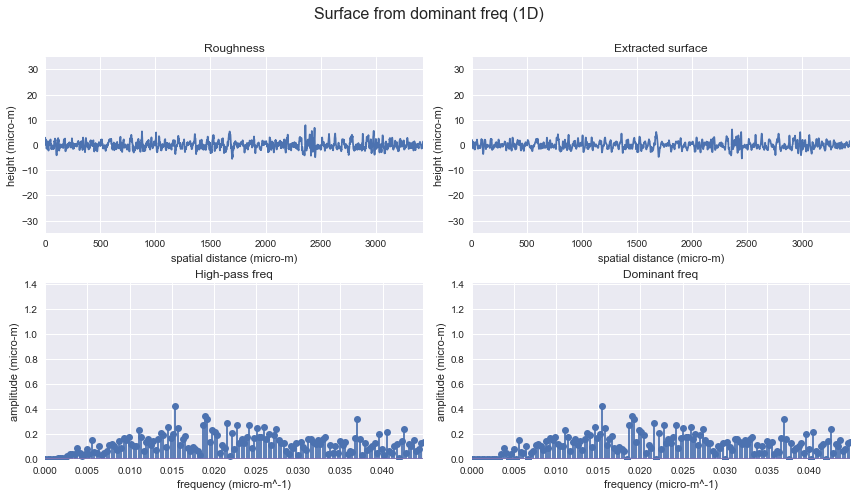

In [73]:
plot_size = (12, 7)
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=plot_size)
f.suptitle("Surface from dominant freq (1D)", fontsize=16)

ax1.plot(data_list, z_inv_high_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Roughness')

ax2.plot(data_list, z_inv_dom_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Extracted surface')

ax3.stem(freq_half, z_fou_high_1D_half)
ax3.set_xlim(0, plt_freq_xlim_1D * 0.07)
ax3.set_ylim(0, plt_freq_zlim_1D * 0.3)
ax3.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax3.title.set_text('High-pass freq')

ax4.stem(freq_half, z_fou_dom_1D_half)
ax4.set_xlim(0, plt_freq_xlim_1D * 0.07)
ax4.set_ylim(0, plt_freq_zlim_1D * 0.3)
ax4.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax4.title.set_text('Dominant freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [74]:
# count amount of dominant freq 1D
f_dom_no_1D = (df_freq_dom_1D['dominant?'] == True).astype(int).values.sum()

print('Amount of dominant freq: ', f_dom_no_1D)

Amount of dominant freq:  606


In [75]:
# compare result

rSq_rou2dom_1D = r2_score(z_inv_high_1D.real, z_inv_dom_1D.real)

print('Roughness to Dominant surface 1D')
print('R-square: ', rSq_rou2dom_1D)

Roughness to Dominant surface 1D
R-square:  0.9184506019684373


## 2D dominant freq

### Autimatically assign cut-off amplitude

In [76]:
# prepare dataframe for loop operation

df_freq = pd.DataFrame(data = z_fou_high_2D_ishift,
                       index = freq_full,
                       columns = freq_full)

df_freq_amp = abs(df_freq)

In [77]:
# prepare list of freq -> to find cut-off amplitude of dominant freq

list_freq_amp = df_freq_amp.values.flatten()
list_freq_amp = sorted(list_freq_amp)

In [78]:
# create table to compare result based on amount of dominant freq

# no_dom_freq_per = np.array([0.0025,0.005,0.01,
#                             0.02,0.04,0.06,0.08,0.1,
#                             0.2,0.4,0.6,0.8,1.0,
#                             1.5,2.0,5.0,10.0,20.0,30.0])

no_dom_freq_per = np.array([10.0,20.0,30.0,40.0,50.0])

df_dom_samp = pd.DataFrame(data = no_dom_freq_per, columns = ['no_f_per'])
df_dom_samp['no_f'] = df_dom_samp['no_f_per'] * len(list_freq_amp) / 100
df_dom_samp['no_f_int'] = df_dom_samp['no_f'].astype(int) + 1
df_dom_samp['f_dom_amp_c'] = np.zeros(len(no_dom_freq_per))
df_dom_samp['result_error'] = np.zeros(len(no_dom_freq_per))

In [79]:
# find cut-off amplitude for dominant freq

for i in range(len(no_dom_freq_per)):
    df_dom_samp.loc[i,'f_dom_amp_c'] = list_freq_amp[-df_dom_samp.loc[i,'no_f_int']]
    
df_dom_samp.head()

no_f_per       no_f  no_f_int  f_dom_amp_c  result_error
0      10.0   482241.6    482242  2793.613212           0.0
1      20.0   964483.2    964484  1737.608027           0.0
2      30.0  1446724.8   1446725  1345.863409           0.0
3      40.0  1928966.4   1928967  1106.565702           0.0
4      50.0  2411208.0   2411209   925.863410           0.0

D:\Program\Python\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


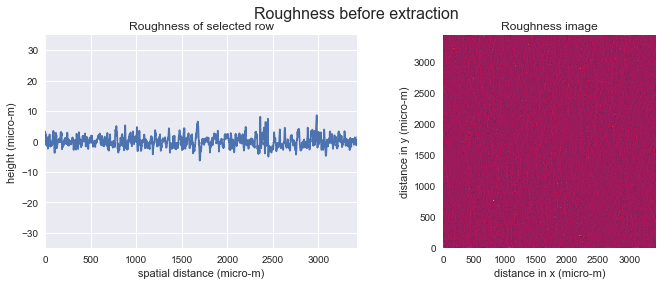

In [80]:
# roughness plot

plot_size = (10, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Roughness before extraction", fontsize=16)

ax1.plot(data_list, z_inv_select_high)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Roughness of selected row')

ax2.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Roughness image')
ax2.grid(False)


plt.tight_layout()
f.subplots_adjust(top=0.88)

In [81]:
def find_error_dom_f(no_f_per, freq_dom_amp_c):

    df_freq_dom = df_freq.copy()
    
    for x in df_freq.columns:
        df_freq_dom[x] = np.where(
            df_freq_amp[x] > freq_dom_amp_c,
            df_freq_dom[x],
            0.0
        )
    
    z_fou_dom = df_freq_dom.values
    z_inv_dom_2D = ifft2(z_fou_dom)

#----------------------------------------------------------------------------------------------------------------------------#
    
    # find error
    
    rSq_rou2dom_2D = r2_score(z_inv_high_2D.real, z_inv_dom_2D.real)
    
#----------------------------------------------------------------------------------------------------------------------------#

    # extract row for 1D plot

    if x_or_y == 'x': 
        z_inv_select_dom = z_inv_dom_2D[:, row_no]
        
    if x_or_y == 'y':
        z_inv_select_dom = z_inv_dom_2D[row_no, :]
    
#----------------------------------------------------------------------------------------------------------------------------#

    # plot graph to compare
    
    
    title = 'No. of selected dom freq: ' + str(no_f_per) + ', R-Square error: ' + str("{0:.2f}".format(rSq_rou2dom_2D))
        
    plot_size = (10, 4)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
    f.suptitle(title, fontsize=16)
    axis_dist = (0, data_len, 0, data_len)                                             # assign axis for spatial domain
    axis_freq = (0, samp_rate, 0, samp_rate)                                           # assign axis for freq domain

    ax1.plot(data_list, z_inv_select_dom)
    ax1.set_xlim(0, plt_dist_xlim_1D)
    ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
    ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
    ax1.title.set_text('Roughness of selected row')

    ax2.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
    ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax2.title.set_text('Roughness image')
    ax2.grid(False)

    plt.tight_layout()
    f.subplots_adjust(top=0.88)
    
    
    return rSq_rou2dom_2D

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]D:\Program\Python\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.71s/it]


no_f_per       no_f  no_f_int  f_dom_amp_c  result_error
0      10.0   482241.6    482242  2793.613212      0.911649
1      20.0   964483.2    964484  1737.608027      0.948005
2      30.0  1446724.8   1446725  1345.863409      0.966179
3      40.0  1928966.4   1928967  1106.565702      0.977898
4      50.0  2411208.0   2411209   925.863410      0.986013

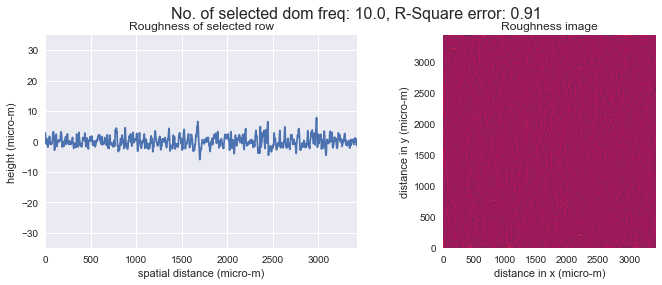

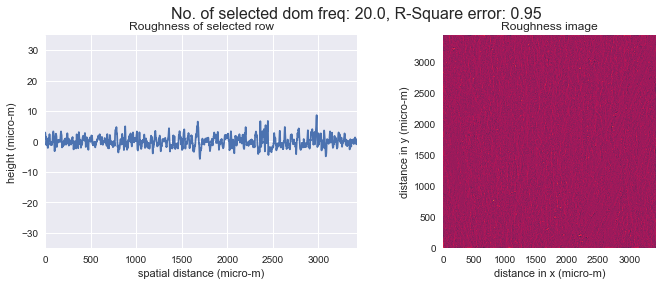

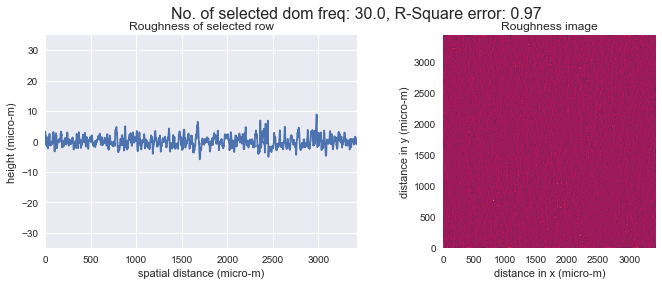

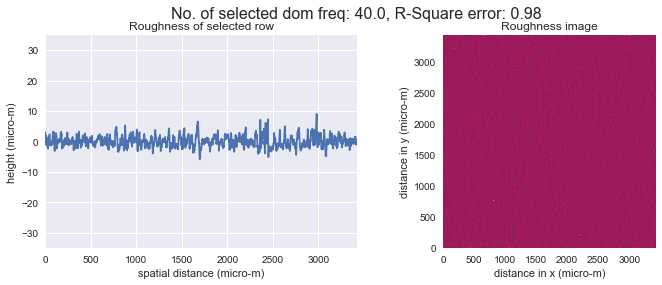

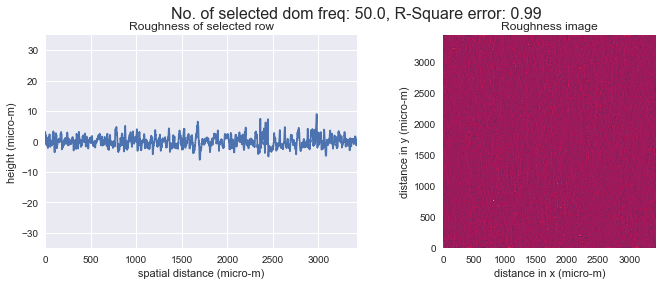

In [82]:
# find result error between roughness and extracted surface

for i in tqdm(range(len(no_dom_freq_per))):
    df_dom_samp.loc[i,'result_error'] = find_error_dom_f(df_dom_samp.loc[i,'no_f_per'], df_dom_samp.loc[i,'f_dom_amp_c'])
    
df_dom_samp

In [83]:
# automatically assign cut-off dominant amplitude by acceptable percentage of error

for i in range(len(no_dom_freq_per)):
    if df_dom_samp.loc[i,'result_error'] > accept_dom_rSqua_2D:
        freq_dom_amp_c_2D = df_dom_samp.loc[i,'f_dom_amp_c']
        break
            
freq_dom_amp_c_2D

1345.8634088932245

### Extraction operation

In [84]:
# remain only dominant freq in matrix

df_freq_dom = df_freq.copy()
    
for x in df_freq.columns:
    df_freq_dom[x] = np.where(
        df_freq_amp[x] > freq_dom_amp_c_2D,
        df_freq_dom[x],
        0.0
    )

In [85]:
z_fou_dom = df_freq_dom.values
z_inv_dom_2D = ifft2(z_fou_dom)

z_fou_dom_shift = fftshift(z_fou_dom)
z_fou_dom_ishift = ifftshift(z_fou_dom_shift)

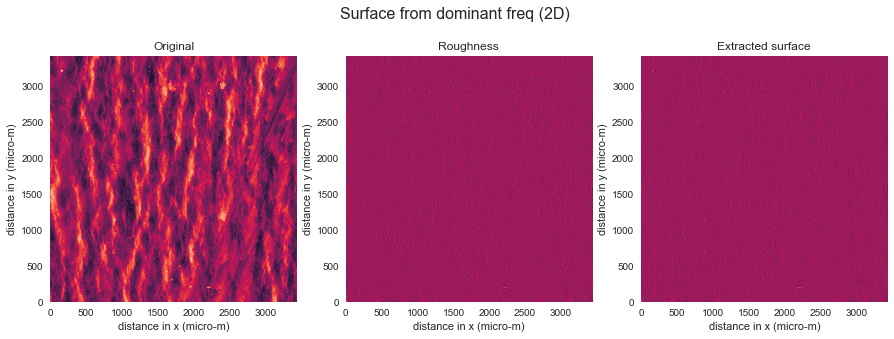

In [86]:
# plot surface image

plot_size = (15, 5)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Surface from dominant freq (2D)", fontsize=16)

ax1.imshow(z_inv_smooth_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Original')
ax1.grid(False)

ax2.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Roughness')
ax2.grid(False)

ax3.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist) 
ax3.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax3.title.set_text('Extracted surface')
ax3.grid(False)

D:\Program\Python\lib\site-packages\matplotlib\transforms.py:963: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


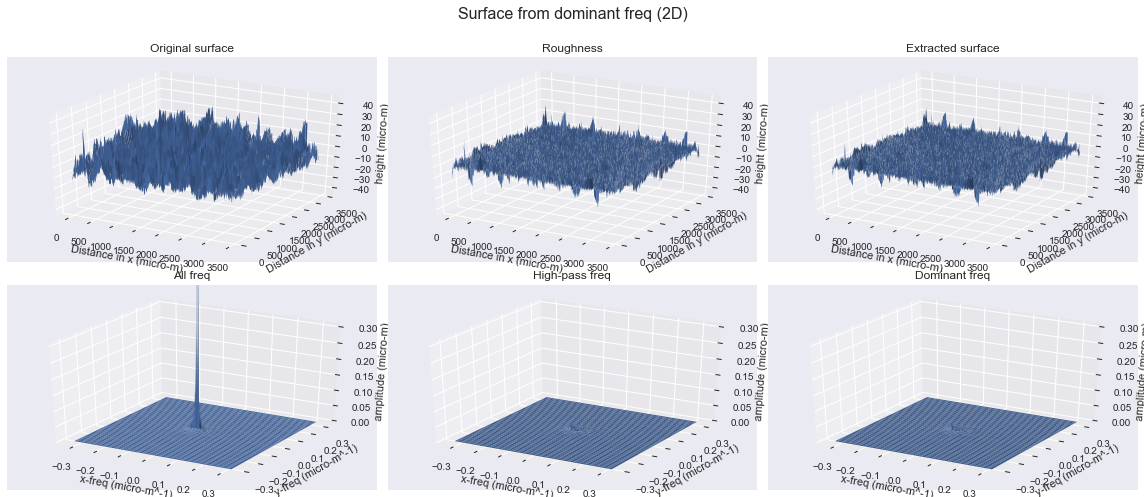

In [87]:
# plot surface 3D

plot_size = (16, 7)
fig = plt.figure(figsize=plot_size)
fig.suptitle('Surface from dominant freq (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(2, 3, 1, projection='3d') 

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Original surface')


# Second subplot
ax = fig.add_subplot(2, 3, 2, projection='3d')

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness')


# third subplot
ax = fig.add_subplot(2, 3, 3, projection='3d')

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_dom_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Extracted surface')


# fourth subplot
ax = fig.add_subplot(2, 3, 4, projection='3d')          

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_smooth_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('All freq')


# fifth subplot
ax = fig.add_subplot(2, 3, 5, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_high_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('High-pass freq')


# sixth subplot
ax = fig.add_subplot(2, 3, 6, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_dom_shift)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Dominant freq')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [88]:
# count amount of dominant freq
f_dom_no = (df_freq_dom != 0).astype(int).values.sum()

print('Amount of dominant freq: ', f_dom_no)

Amount of dominant freq:  1446724


In [89]:
# compare result 

rSq_rou2dom_2D = r2_score(z_inv_high_2D.real, z_inv_dom_2D.real)

print('Roughness to Dominant surface 2D')
print('R-square: ', rSq_rou2dom_2D)

Roughness to Dominant surface 2D
R-square:  0.9661792459663497


# Import data to csv file

## 1D import file

### Variables of full-frequency

In [90]:
df_excel_1D = df_freq_dom_1D[['freq', 'high_conv', 'amplitude', 'dominant?']].copy()

# keep only rows with dominant freq
df_excel_1D = df_excel_1D[(df_excel_1D[['dominant?']] == True).any(axis=1)]
df_excel_1D = df_excel_1D.reset_index(drop=True)

In [91]:
df_excel_1D = df_excel_1D.drop(['dominant?'], axis=1)
df_excel_1D = df_excel_1D.rename(index=str, columns={'freq':'f(um)^-1', 
                                                     'high_conv':'FourierCoef', 
                                                     'amplitude':'A(um)'
                                                    })

df_excel_1D['FourierCoef'] = df_excel_1D['FourierCoef'] / data_pnts
df_excel_1D['Phs(rad)'] = np.angle(df_excel_1D['FourierCoef'])

### Variables of half-frequency

In [92]:
# keep only positive freq

df_excel_1D_pos = df_excel_1D.copy()
df_excel_1D_pos = df_excel_1D_pos[(df_excel_1D_pos[['f(um)^-1']] >= 0).any(axis=1)]
df_excel_1D_pos = df_excel_1D_pos.reset_index(drop=True)

In [93]:
# correct the amplitude by *2

f_dom_no_1D_pos = int(f_dom_no_1D/2)

df_excel_1D_pos['FourierCoef'] = np.where(
    df_excel_1D_pos['f(um)^-1'] == 0,
    df_excel_1D_pos['FourierCoef'],
    2 * df_excel_1D_pos['FourierCoef']
)

df_excel_1D_pos['A(um)'] = np.where(
    df_excel_1D_pos['f(um)^-1'] == 0,
    df_excel_1D_pos['A(um)'],
    2 * df_excel_1D_pos['A(um)']
)

df_excel_1D_pos.head()

f(um)^-1                                   FourierCoef     A(um)  Phs(rad)
0  0.003497    (-0.02965689340988484-0.0333467151278124j)  0.044627 -2.297696
1  0.003789   (0.08390668400499891-0.027601424177154017j)  0.088330 -0.317804
2  0.004080  (0.052591817133973186+0.012025917380439791j)  0.053949  0.224800
3  0.004663   (0.01607691129221696+0.042113620187183655j)  0.045078  1.206120
4  0.004954   (0.008538468140144664+0.08374632353265787j)  0.084180  1.469191

In [94]:
print('Amount of dominant freq (full): ', f_dom_no_1D)
print('Amount of dominant freq (half): ', f_dom_no_1D_pos)

Amount of dominant freq (full):  606
Amount of dominant freq (half):  303


In [95]:
# # import dataframe to csv

# df_excel_1D_pos.to_csv('onefile_variables_1D.csv', index=False)

### Height of dominant surface

In [96]:
df_excel_1D_z_dom = pd.DataFrame(data = data_list, columns = ['x(um)'])
df_excel_1D_z_dom['z(um)'] = z_inv_dom_1D.real

df_excel_1D_z_dom.head()

x(um)     z(um)
0  0.0000  2.017056
1  1.5625  2.026395
2  3.1250  1.336892
3  4.6875  0.598876
4  6.2500  0.826039

In [97]:
# # cut length of imported height as assign

# if assign_csv_len == 'y':
#     df_excel_1D_z_dom = df_excel_1D_z_dom.iloc[0:csv_len_1D]

# print('Processed length: ', data_pnts)
# print('Imported length:  ', len(df_excel_1D_z_dom))

In [98]:
# # import dataframe to csv

# df_excel_1D_z_dom.to_csv('onefile_height_1D.csv', index=False)

## 2D import file

### Variables of full-frequency

In [99]:
df_freq_dom = pd.DataFrame(data = z_fou_dom_ishift)

# assign index to dataframe
df_freq_dom.index = freq_full
df_freq_dom.columns = freq_full

In [100]:
# unpivot table of df_freq_dom

df_excel_2D = df_freq_dom.unstack().reset_index(name='FourierCoef')
df_excel_2D.rename(columns={'level_0': 'fx(um)^-1', 'level_1': 'fy(um)^-1'}, inplace=True)

In [101]:
# assign amplitude and phase

df_excel_2D['FourierCoef'] = df_excel_2D['FourierCoef'] / data_pnts**2
df_excel_2D['A(um)'] = np.abs(df_excel_2D['FourierCoef'])
df_excel_2D['Phs(rad)'] = np.angle(df_excel_2D['FourierCoef'])


# remain only dominant freq

df_excel_2D = df_excel_2D[(df_excel_2D[['FourierCoef']] != 0).any(axis=1)]
df_excel_2D = df_excel_2D.reset_index(drop=True)

### Variables of half-frequency

In [102]:
# remain only freq in half positive quarters

df_excel_2D_half = df_excel_2D.copy()
df_excel_2D_half = df_excel_2D_half[(df_excel_2D_half[['fx(um)^-1']] >= 0).any(axis=1)]
df_excel_2D_half = df_excel_2D_half.reset_index(drop=True)

In [103]:
# correct the amplitude by *2

f_dom_no_half = len(df_excel_2D_half)

df_excel_2D_half['FourierCoef'] = np.where(
    df_excel_2D_half['fx(um)^-1'] == 0,
    df_excel_2D_half['FourierCoef'],
    2 * df_excel_2D_half['FourierCoef']
)

df_excel_2D_half['A(um)'] = np.where(
    df_excel_2D_half['fx(um)^-1'] == 0,
    df_excel_2D_half['A(um)'],
    2 * df_excel_2D_half['A(um)']
)

df_excel_2D_half.head()

fx(um)^-1  fy(um)^-1                                       FourierCoef  \
0        0.0   0.001749  (0.00022959847532498265+0.00041192887617345653j)   
1        0.0   0.002040  (2.3442213412057324e-05+0.00039236019672165076j)   
2        0.0   0.002332    (0.0008105640900997617-0.0007956978047367692j)   
3        0.0   0.002623  (-0.00039997748129679504-0.0012988693186243066j)   
4        0.0   0.002914  (-0.00011717540288143918-0.0012668897563041482j)   

      A(um)  Phs(rad)  
0  0.000472  1.062309  
1  0.000393  1.511121  
2  0.001136 -0.776143  
3  0.001359 -1.869524  
4  0.001272 -1.663025

In [104]:
print('Amount of dominant freq (full): ', f_dom_no)
print('Amount of dominant freq (half): ', f_dom_no_half)

Amount of dominant freq (full):  1446724
Amount of dominant freq (half):  724011


In [105]:
# # import dataframe to csv

# df_excel_2D_half.to_csv('onefile_variables_2D.csv', index=False)

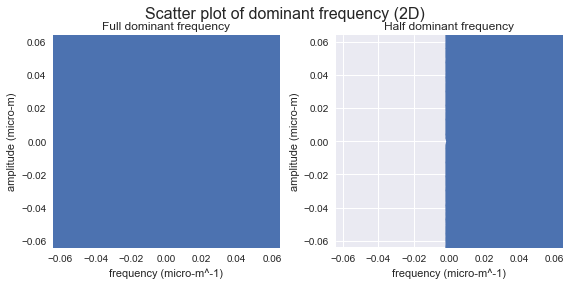

In [106]:
# scatter plot to compare full & half dominant freq

axis_freq = (0, samp_rate, 0, samp_rate)

plot_size = (8, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Scatter plot of dominant frequency (2D)", fontsize=16)


## plot1
data = df_excel_2D[['fx(um)^-1', 'fy(um)^-1']].values
x1, y1 = data.T

ax1.scatter(x1,y1)
ax1.set_xlim((-samp_rate * 0.1, samp_rate * 0.1))
ax1.set_ylim((-samp_rate * 0.1, samp_rate * 0.1))
ax1.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax1.title.set_text('Full dominant frequency')


## plot2
data = df_excel_2D_half[['fx(um)^-1', 'fy(um)^-1']].values
x2, y2 = data.T

ax2.scatter(x2,y2)
ax2.set_xlim((-samp_rate * 0.1, samp_rate * 0.1))
ax2.set_ylim((-samp_rate * 0.1, samp_rate * 0.1))
ax2.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax2.title.set_text('Half dominant frequency')


plt.tight_layout()
f.subplots_adjust(top=0.88)

### Height of dominant surface

In [107]:
df_excel_2D_z_dom = pd.DataFrame(data = z_inv_dom_2D.real, columns = data_list)
df_excel_2D_z_dom.index = data_list

df_excel_2D_z_dom.iloc[0:5,0:5]

0.0000     1.5625     3.1250     4.6875     6.2500
0.0000 -5.834625  -9.249897  -9.324813  -8.986669  -8.151733
1.5625 -8.788560 -12.491337 -12.107649 -11.932314 -10.954223
3.1250 -9.420068 -11.639813 -10.886381  -9.209572  -8.899028
4.6875 -9.153030 -10.205731  -9.117544  -6.967247  -7.021859
6.2500 -8.127418  -9.153825  -8.484365  -6.331693  -5.752762

In [108]:
# cut length of imported height as assign

if assign_csv_len == 'y':
    df_excel_2D_z_dom = df_excel_2D_z_dom.iloc[
        int(data_pnts/2):int(data_pnts/2+csv_len_2D), int(data_pnts/2):int(data_pnts/2+csv_len_2D)]

print('Processed length: ', data_pnts)
print('Imported length:  ', len(df_excel_2D_z_dom))

Processed length:  2196
Imported length:   2196


In [109]:
# unpivot table

temp = df_excel_2D_z_dom.stack()
df_excel_2D_z_dom_melt = pd.DataFrame(temp)
df_excel_2D_z_dom_melt.columns = ['z']
df_excel_2D_z_dom_melt = df_excel_2D_z_dom_melt.reset_index()
df_excel_2D_z_dom_melt = df_excel_2D_z_dom_melt.rename(index=str, columns={'level_0': 'x',
                                                                           'level_1': 'y'})

df_excel_2D_z_dom_melt.head()

x       y         z
0  0.0  0.0000 -5.834625
1  0.0  1.5625 -9.249897
2  0.0  3.1250 -9.324813
3  0.0  4.6875 -8.986669
4  0.0  6.2500 -8.151733

In [110]:
# rearrange data
shiftValue = df_excel_2D_z_dom_melt.iloc[0,0]

df_excel_2D_z_dom_melt['x'] = df_excel_2D_z_dom_melt['x'] - shiftValue - data_len_recon/2
df_excel_2D_z_dom_melt['y'] = df_excel_2D_z_dom_melt['y'] - shiftValue - data_len_recon/2
df_excel_2D_z_dom_melt['z'] = df_excel_2D_z_dom_melt['z']
df_excel_2D_z_dom_melt.columns = ['z', 'x', 'y']

df_excel_2D_z_dom_melt.head()

z        x         y
0 -15.0 -15.0000 -5.834625
1 -15.0 -13.4375 -9.249897
2 -15.0 -11.8750 -9.324813
3 -15.0 -10.3125 -8.986669
4 -15.0  -8.7500 -8.151733

In [111]:
# # import dataframe to csv

# df_excel_2D_z_dom_melt.to_csv('onefile_height_2D.csv', index=False)

# Surface reconstruction

## 1D surface reconstruction

In [112]:
# reconstruct surface by superposition of sinusoidal wave

z_recon_1D_pos = np.zeros(data_pnts_recon)
x = np.array(data_list_recon)

for i in tqdm(range(f_dom_no_1D_pos)):
    
    A = df_excel_1D_pos['A(um)'].iloc[i]
    f = df_excel_1D_pos['f(um)^-1'].iloc[i]
    ph = df_excel_1D_pos['Phs(rad)'].iloc[i]
        
    zi = A * np.cos(2*np.pi*f*x + ph)
    z_recon_1D_pos = z_recon_1D_pos + zi
    
z_recon_1D_pos[0:5]

100%|█████████████████████████████████████████████████████████████████████████████| 303/303 [00:00<00:00, 13785.68it/s]


array([2.01705567, 2.09713839, 1.90105661, 1.41066158, 0.84349668])

In [113]:
df_1D_z_recon = pd.DataFrame(data = data_list_recon, columns = ['x'])
df_1D_z_recon['z'] = z_recon_1D_pos.real

df_1D_z_recon.head()

x         z
0  0.0  2.017056
1  1.0  2.097138
2  2.0  1.901057
3  3.0  1.410662
4  4.0  0.843497

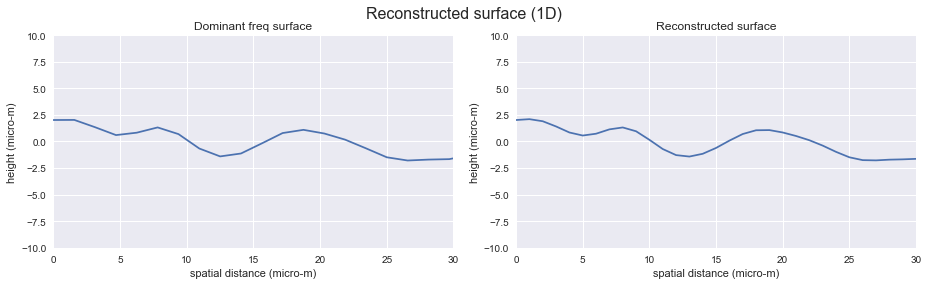

In [114]:
plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Reconstructed surface (1D)", fontsize=16)

ax1.plot(data_list, z_inv_dom_1D.real)
ax1.set_xlim(0, data_len_recon)
ax1.set_ylim(-10, 10)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Dominant freq surface')

ax2.plot(data_list_recon, z_recon_1D_pos)
ax2.set_xlim(0, data_len_recon)
ax2.set_ylim(-10, 10)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Reconstructed surface')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [115]:
# # import dataframe to csv

# df_1D_z_recon.to_csv('1D_recon_WireCut2_1.csv', index=False)

In [116]:
# # compare result

# rSq_dom2recon_1D = r2_score(z_inv_dom_1D.real, z_recon_1D_pos)
# rSq_rou2recon_1D = r2_score(z_inv_high_1D.real, z_recon_1D_pos)

# print('Dominant to reconstructed surface 1D')
# print('R-square: ', rSq_dom2recon_1D)
# print('\nRoughness to reconstructed surface 1D')
# print('R-square: ', rSq_rou2recon_1D)

## 2D surface reconstruction

In [117]:
# reconstruct surface by superposition of sinusoidal wave

z_recon_2D_half = pd.DataFrame(np.zeros((data_pnts_recon, data_pnts_recon)))
x, y = np.meshgrid(data_list_recon, data_list_recon)

for i in tqdm(range(f_dom_no_half)):
    
    A = df_excel_2D_half['A(um)'].iloc[i]
    fx = df_excel_2D_half['fx(um)^-1'].iloc[i]
    fy = df_excel_2D_half['fy(um)^-1'].iloc[i]
    ph = df_excel_2D_half['Phs(rad)'].iloc[i]
    
    zi = A * np.cos(2*np.pi*(fx*x + fy*y) + ph)
    z_recon_2D_half = z_recon_2D_half + zi
    
z_recon_2D_half.iloc[0:5,0:5]

100%|████████████████████████████████████████████████████████████████████████| 724011/724011 [04:09<00:00, 2905.65it/s]


0          1          2          3          4
0  -5.835909  -8.571475  -9.451657  -9.356546  -9.145995
1  -9.531115 -13.632308 -13.755931 -13.662319 -13.867732
2  -8.272469 -11.371716 -11.100746 -10.861848 -10.756773
3  -9.204137 -11.492740 -11.309852 -10.847991  -9.901056
4 -10.007083 -11.791159 -11.456748 -10.797516  -9.392445

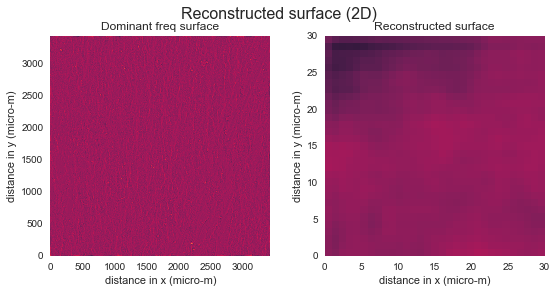

In [118]:
plot_size = (8, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Reconstructed surface (2D)", fontsize=16)

ax1.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Dominant freq surface')
ax1.grid(False)

ax2.imshow(z_recon_2D_half.values.real, extent=axis_dist_recon, vmin=v_min_dist, vmax=v_max_dist) 
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Reconstructed surface')
ax2.grid(False)

plt.tight_layout()
f.subplots_adjust(top=0.88)

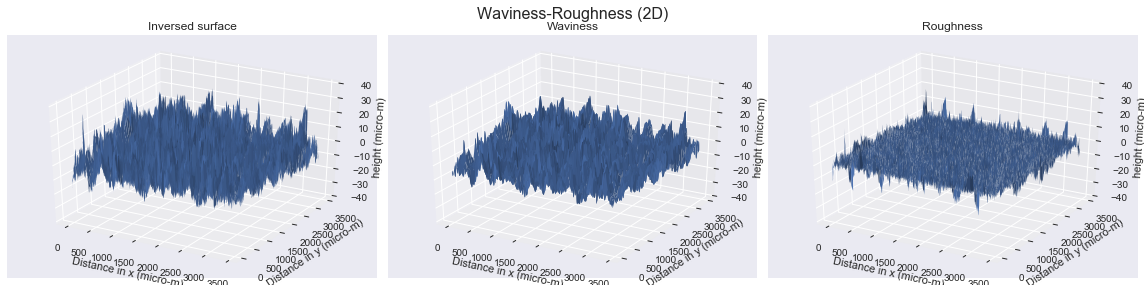

In [119]:
fig = plt.figure(figsize=plt.figaspect(0.25))
fig.suptitle('Waviness-Roughness (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 3, 1, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Inversed surface')


# Second subplot
ax = fig.add_subplot(1, 3, 2, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_low_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Waviness')


# third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [120]:
# prepare axis for roughness and dominant plot

plot_max_loc = 0

for i in range(len(data_list)):
    if data_list[len(data_list)-1-i] < elemsize_recon:
        plot_max_loc = len(data_list)-1-i
        break

plot_data_list = x_list[0:plot_max_loc]
        
print(plot_max_loc)
print(data_list[plot_max_loc])

19
29.6875


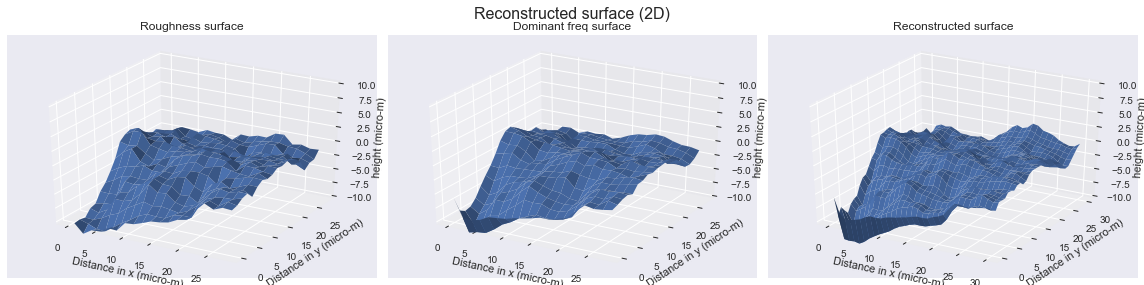

In [121]:
fig = plt.figure(figsize=plt.figaspect(0.25))
fig.suptitle('Reconstructed surface (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 3, 1, projection='3d')           

X = plot_data_list
Y = plot_data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real
Z = Z[0: plot_max_loc, 0: plot_max_loc]

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-10, 10)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness surface')


# Second subplot
ax = fig.add_subplot(1, 3, 2, projection='3d')           

X = plot_data_list
Y = plot_data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_dom_2D.real
Z = Z[0: plot_max_loc, 0: plot_max_loc]

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-10, 10)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Dominant freq surface')


# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')           

X = data_list_recon
Y = data_list_recon
X, Y = np.meshgrid(X, Y)
Z = z_recon_2D_half.values.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-10, 10)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Reconstructed surface')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [122]:
# # import dataframe to csv

# z_recon_2D_half.to_csv(fileName2D + '_pivot.csv')

In [123]:
# compare result

rSq_dom2recon_2D = r2_score(z_inv_dom_2D.real[0: data_pnts_recon, 0: data_pnts_recon], z_recon_2D_half.values.real)
rSq_rou2recon_2D = r2_score(z_inv_high_2D.real[0: data_pnts_recon, 0: data_pnts_recon], z_recon_2D_half.values.real)

print('Dominant to reconstructed surface 2D')
print('R-square: ', rSq_dom2recon_2D)
print('\nRoughness to reconstructed surface 2D')
print('R-square: ', rSq_rou2recon_2D)

Dominant to reconstructed surface 2D
R-square:  -1.9337689135075162

Roughness to reconstructed surface 2D
R-square:  -1.8839615490797441


In [124]:
# unpivot table

temp = z_recon_2D_half.stack()
df2D_recon_melt = pd.DataFrame(temp)
df2D_recon_melt.columns = ['z']
df2D_recon_melt = df2D_recon_melt.reset_index()
df2D_recon_melt = df2D_recon_melt.rename(index=str, columns={'level_0': 'x', 'level_1': 'y'})
df2D_recon_melt.columns = ['z', 'x', 'y']

df2D_recon_melt.head()

z  x         y
0  0  0 -5.835909
1  0  1 -8.571475
2  0  2 -9.451657
3  0  3 -9.356546
4  0  4 -9.145995

In [125]:
# # rearrange data

# df2D_recon_melt['x'] = df2D_recon_melt['x']
# df2D_recon_melt['y'] = df2D_recon_melt['y'] - data_len_recon/2
# df2D_recon_melt['z'] = df2D_recon_melt['z']
# df2D_recon_melt.columns = ['z', 'x', 'y']

# df2D_recon_melt.head()

In [131]:
# prepare file name

if elemsize_recon == 30:
    elemForName = '_30pnts'
if elemsize_recon == 50:
    elemForName = '_50pnts'    

if trim_command == 'n':
    trimForName = '_noTrim'
if trim_command == 'y': 
    trimForName = '_trim' + str(trim_min) + '-' + str(trim_max) 

outputFileName = 'recon2D_' + input_file[:-4] + elemForName + trimForName

print(outputFileName)

recon2D_149-1A1_30pnts_noTrim


In [132]:
# import dataframe to csv (reconstructed surface)

df2D_recon_melt.to_csv(outputFileName + '.csv', index=False)